*General dependencies*

In [1]:
#Change it accoprding to your Hardware
#If you have a NVIDIA GPU, read the "install TF and OpenCV with CUDA" section on this notebook
TF_GPU = 1

In [2]:
#!pip install numpy
#!pip install matplotlib

#We will use virtualenv to create a separate envinment
#!pip install virtualenv

In [3]:
#Activating the separate environment

#!virtualenv TF_GPU

**Install TensorFlow and OpenCV with CUDA**

https://thinkinfi.com/conda-install-tensorflow-gpu-jupyter/

OBS: For Python 3.8.X. If you need the last version will be necessary recompile TF or use Linux.

- First: Install CUDA Drivers
  
TensorFlow and CUDA drivers are directly conected, you need to install the correct version of each one.
In the link below, you can find a tabble with the TF version and Supported CUDA
https://www.tensorflow.org/install/source


For this project, we will be using TD 2.10, because they are not compiling TF-GPU for Windows after the 2.10 version.
Dur to this, we will need to install CUDA 11 drivers.

You can download the NVIDIA CUDA drivers from the link: 

https://developer.nvidia.com/cuda-11-8-0-download-archive?target_os=Windows&target_arch=x86_64&target_version=11&target_type=exe_local

- Install cuDNN

  
  To have support of Deep Neural Network through CUDA, you need to install cuDNN.
  cuDNN is compiled for the specific CUDA driver version too, you can download the correct version for you CUDA installation from the link (for CUDA 11 in our case):
  
  https://developer.nvidia.com/rdp/cudnn-archive


  After, extract the files, and copy each dll and .h from its folder to the same folder in CUDA Driver Directory installation.

  For example:
      Copy all "lib\x64\*.dll" to "C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\lib"


      Do it for the include and lib files too.

  Now, you are prepared to install TensorFlow GPU.

- Install TensorFlow-GPU

  TF-gpu is only disponible in its 2.10 verion of Windows, that is only compatible with Python 3.7-3.9.
 
  !pip install tensorflow-gpu==2.10

- OpenCV Cuda

    https://medium.com/analytics-vidhya/build-opencv-from-source-with-cuda-for-gpu-access-on-windows-5cd0ce2b9b37

  Download CMake: https://cmake.org/download/
  
  Download OpenCV Source Code: https://opencv.org/releases/
  
  Install CMake
  
  Extract OpenCD SRC in a folder
  
  Create "build" directory
  
  Open the OpenCVDetectPython.cmake into "cmake" dir and
  
  

In [4]:
default_resolution = 224

In [5]:
def resize(image):
    # Define the desired width and height
    desired_width, desired_height = 224, 224

    # Get the dimensions of the original image
    height, width = image.shape[:2]

    # Calculate the resizing ratio
    width_ratio = desired_width / width
    height_ratio = desired_height / height

    # Choose the minimum ratio to ensure the image fits within the new size
    ratio = min(width_ratio, height_ratio)

    # Calculate the new dimensions of the image
    new_width = int(width * ratio)
    new_height = int(height * ratio)

    # Resize the image to the new dimensions
    resized_image = cv2.resize(image, (new_width, new_height))

    # Create a blank image with the desired size and random background colors (noise)
    background_noise = np.random.randint(0, 256, (desired_height, desired_width, 3), dtype=np.uint8)

    # Calculate the starting coordinates to paste the resized image in the center
    x_start = (desired_width - new_width) // 2
    y_start = (desired_height - new_height) // 2

    # Paste the resized image in the center of the noisy background
    background_noise[y_start:y_start + new_height, x_start:x_start + new_width] = resized_image

    return background_noise

In [6]:
try:
    import tensorflow as tf
except ImportError:
    #Installing TensorFlow GPU 2.10 to use CUDA 11
    if TF_GPU:
        !pip install tensorflow-gpu==2.10
    else:
        !pip install tensorflow

    import tensorflow as tf
    from tensorflow import keras

from tensorflow import keras
from tensorflow.keras import mixed_precision

In [7]:
#Importing tensorflow and keras API
#from tensorflow import keras

# Importing numpy and pyplot
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pandas as pd
from itertools import islice

import time  #Importing time library

#import cv2  # ou from PIL import Image

In [8]:
print("ensorFlow Version:", tf.__version__)    #Checking TensorFlow version
print("CUDA support:", tf.test.is_built_with_cuda())  #Checking CUDA support
print("GPU:", tf.config.list_physical_devices('GPU')) #Checking available GPUs
print("---------------------------------------------")
print("OpenCV Version:", cv2.__version__) 
print("CUDA support:",cv2.cuda.getCudaEnabledDeviceCount())

ensorFlow Version: 2.10.0
CUDA support: True
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
---------------------------------------------
OpenCV Version: 4.8.1
CUDA support: 0


In [9]:
import sys
print(sys.executable)

C:\Users\josia\AppData\Roaming\jupyterlab-desktop\jlab_server\python.exe


In [10]:
#Loading the CSV file
df = pd.read_csv('../BirdsDataset/birds.csv')

#Defining root directory
root_directory= '../BirdsDataset/'                      

#from https://www.birdlist.org/nam/canada/saskatchewan/saskatchewan.htm
sk_species = pd.read_csv('SK_species.csv')

In [11]:
#Checking the first 4 lines
#df.head(4)

In [12]:
#sk_species.head(4)

- R: Resident, present  year around
- N: Nests in the area but absent during part of the year
- M: Migrant, non-breeding. May spend a short period or the entire winter
- W: Wintering; stays in the area, while its primary nesting range is elsewhere
- E: National endemic
National endemic.

In [13]:
status_values = ["R", "M", "N", "W", "E"]
filtered_data = sk_species[np.isin(sk_species['status'], status_values)]
print(filtered_data.shape)
filtered_data.head(4)   #Ploting only the species marked as "status_values" status

(161, 3)


,scientific name,labels,status
0,PERDIX PERDIX,GREY PARTRIDGE,R
6,OXYURA JAMAICENSIS,RUDDY DUCK,M
8,CYGNUS COLUMBIANUS,TUNDRA SWAN,M
9,ANSER ALBIFRONS,GREATER WHITE-FRONTED GOOSE,M


In [14]:
#Filtering SK species on the dataset
filtered_species =  df[np.isin(df['scientific name'], sk_species['scientific name'])]
filtered_species.shape

(16027, 5)

In [15]:
df=filtered_species

In [16]:
#classe_names
class_names = df['labels'].unique()
class_names.shape[0]

92

In [17]:
len(df)

16027

In [18]:
specie_id = 0
for i in range(class_names.shape[0]):
    df.loc[df['labels'] == class_names[i], 'class id'] = specie_id
    
    #print(class_names[i])
    specie_id+=1

In [19]:
df['filepaths'] = root_directory + df['filepaths']


In [20]:
df

,class id,filepaths,labels,data set,scientific name
2422,0,../BirdsDataset/train/AMERICAN BITTERN/001.jpg,AMERICAN BITTERN,train,BOTAURUS LENTIGINOSUS
2423,0,../BirdsDataset/train/AMERICAN BITTERN/082.jpg,AMERICAN BITTERN,train,BOTAURUS LENTIGINOSUS
2424,0,../BirdsDataset/train/AMERICAN BITTERN/042.jpg,AMERICAN BITTERN,train,BOTAURUS LENTIGINOSUS
2425,0,../BirdsDataset/train/AMERICAN BITTERN/004.jpg,AMERICAN BITTERN,train,BOTAURUS LENTIGINOSUS
2426,0,../BirdsDataset/train/AMERICAN BITTERN/005.jpg,AMERICAN BITTERN,train,BOTAURUS LENTIGINOSUS
...,...,...,...,...,...
89840,91,../BirdsDataset/valid/RED CROSSBILL/5.jpg,RED CROSSBILL,valid,LOXIA CURVIROSTRA
89841,91,../BirdsDataset/valid/RED CROSSBILL/2.jpg,RED CROSSBILL,valid,LOXIA CURVIROSTRA
89842,91,../BirdsDataset/valid/RED CROSSBILL/4.jpg,RED CROSSBILL,valid,LOXIA CURVIROSTRA
89843,91,../BirdsDataset/valid/RED CROSSBILL/3.jpg,RED CROSSBILL,valid,LOXIA CURVIROSTRA


In [21]:
# Creating a mask separation for training and test data
train_mask = df['filepaths'].str.contains('train/')  
test_mask = df['filepaths'].str.contains('test/|valid/')

# Applying the mask to separate the datasets
train_data = df[train_mask]
test_data = df[test_mask]

#Visualizing the datasets
print("Train Dataset:")
print(train_data.head())

print("\nTest Dataset:")
print(test_data.head())



Train Dataset:
      class id                                       filepaths  \
2422         0  ../BirdsDataset/train/AMERICAN BITTERN/001.jpg   
2423         0  ../BirdsDataset/train/AMERICAN BITTERN/082.jpg   
2424         0  ../BirdsDataset/train/AMERICAN BITTERN/042.jpg   
2425         0  ../BirdsDataset/train/AMERICAN BITTERN/004.jpg   
2426         0  ../BirdsDataset/train/AMERICAN BITTERN/005.jpg   

                labels data set        scientific name  
2422  AMERICAN BITTERN    train  BOTAURUS LENTIGINOSUS  
2423  AMERICAN BITTERN    train  BOTAURUS LENTIGINOSUS  
2424  AMERICAN BITTERN    train  BOTAURUS LENTIGINOSUS  
2425  AMERICAN BITTERN    train  BOTAURUS LENTIGINOSUS  
2426  AMERICAN BITTERN    train  BOTAURUS LENTIGINOSUS  

Test Dataset:
       class id                                    filepaths  \
84710         0  ../BirdsDataset/test/AMERICAN BITTERN/1.jpg   
84711         0  ../BirdsDataset/test/AMERICAN BITTERN/2.jpg   
84712         0  ../BirdsDataset/test/A

In [22]:
#Checking how many images we have in the train dataset
train_data.shape[0]

15107

In [23]:
n_images_per_class_to_load = 240 #Change it for the number of images that you would like to load
n_class = class_names.shape[0]   #Chanfe it for the number of classes that you would like to load

In [24]:
def load_images_and_labels(df, n_images_per_class_to_load):
    local_images = []
    local_labels = []

    for class_id in range(df['class id'].max() + 1):
        filtered_images = df[df['class id'] == class_id]

        n_images_per_class_to_load_int = n_images_per_class_to_load
        if n_images_per_class_to_load_int > len(filtered_images):
            n_images_per_class_to_load_int = len(filtered_images)

        for index, row in islice(filtered_images.iterrows(), n_images_per_class_to_load_int):
            path = row['filepaths']  #Creating the path
            image_path = os.path.join(path)  # Creating the full path
            image = cv2.imread(image_path)   #Reading the image
            

            # Checking ig the image is loaded
            if local_images is not None:                
                local_images.append(resize(image))   #Resizing the image using the custom resize function
                local_labels.append(int(row['class id']))  #Getting the label

    return local_images, local_labels

In [25]:
train_images, train_labels = load_images_and_labels(train_data, n_images_per_class_to_load)
test_images, test_labels = load_images_and_labels(test_data, n_images_per_class_to_load)

In [26]:
from scipy.sparse import coo_matrix

from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)


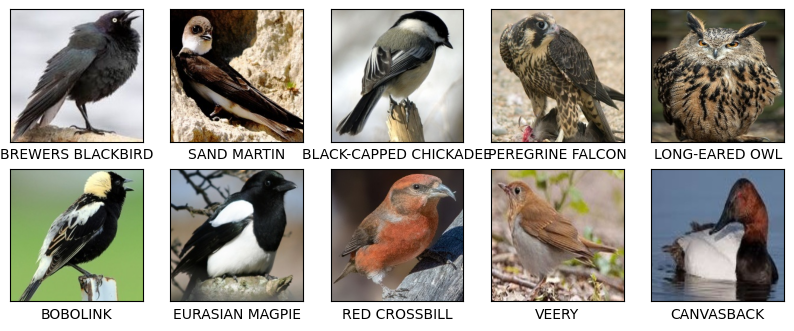

In [27]:
#Printing the first 10 images of the train dataset with its classification
#in grid of 5 by 5
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)   
    plt.imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))  
    plt.xlabel(class_names[train_labels[i]])
plt.show()

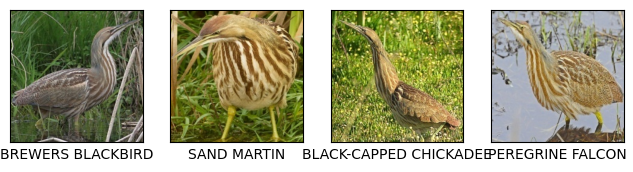

In [28]:
#Printing the first 4 images of the train dataset with its classification
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)    
    plt.imshow(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB))  
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [29]:
#Reset and clear session
tf.keras.backend.clear_session

#Changing the precision to float16
#It is suficient since we are working with images with 8bits color deph for each channel
#It will reduce the memory amount and reduce the processing time
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

<function keras.backend.clear_session()>

In [30]:
#Converting to numpy array
train_images = np.array(train_images)
test_images = np.array(test_images)

# Converter train_labels para um NumPy array
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [31]:
train_labels

array([16, 74, 12, ..., 33,  5, 45])

In [32]:
class_counts = np.bincount(train_labels)
class_counts

array([170, 158, 155, 179, 139, 147, 160, 137, 132, 132, 154, 173, 133,
       137, 167, 157, 183, 177, 192, 163, 184, 160, 185, 180, 162, 161,
       182, 177, 161, 141, 152, 203, 185, 157, 154, 157, 154, 138, 158,
       155, 160, 184, 158, 162, 151, 135, 173, 155, 204, 175, 160, 157,
       190, 160, 135, 209, 153, 139, 160, 152, 163, 156, 160, 160, 133,
       200, 202, 152, 152, 132, 174, 152, 186, 135, 151, 156, 197, 164,
       160, 190, 200, 185, 155, 181, 137, 163, 190, 138, 153, 214, 202,
       191], dtype=int64)

In [33]:
print("Checking the max and min number of images on the dataset")
print('Max: ' + str(np.max(class_counts)))
print('Min: ' + str(np.min(class_counts)))

Checking the max and min number of images on the dataset
Max: 214
Min: 132


In [34]:
# https://www.tensorflow.org/tutorials/images/classification?hl=pt-br
# https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/
# https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

from tensorflow.keras.regularizers import l2

#Distribution strategy - This will enable TF to use CPU and GPU
strategy = tf.distribute.MirroredStrategy()

# Defining a function to create our model
def create_model():   
    base_model = tf.keras.applications.InceptionV3(include_top= False, weights='imagenet')
    
    #Freezing the Inception model
    base_model.trainable = False

    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(224, 224, 3)),            
        base_model,                
        
        layers.Conv2D(1024, 3, padding='same', activation='relu'),   
        layers.BatchNormalization(),    
        layers.MaxPooling2D(name = "max_pooling_layer"),        
        layers.Flatten(),       
        
        layers.Dense(3312, activation='LeakyReLU'),  
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.3),
        
        layers.Dense(1472, activation='LeakyReLU'),  
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.3),   

        layers.Dense(736, activation='relu'),     
        layers.Dropout(0.25),           
        
        layers.Dense(368, activation='relu'),     
        layers.Dropout(0.20),   

        layers.Dense(164, activation='relu'),     
        layers.Dropout(0.15),         
        
        layers.Dense(n_class, activation='softmax', kernel_regularizer=l2(0.1))  
    ])

    return model

# Creating the model
with strategy.scope():
    model = create_model()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adamax(),  
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']
             )

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Training Batch size
batch_size = 64

#Data generator for data augmentation
datagen_augmented = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.25,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.1
)

In [37]:
# Batch generator for the augmented data
generator_augmented = datagen_augmented.flow(train_images, train_labels, batch_size=batch_size, shuffle=True, subset='training')

In [38]:
# Batch generator for the validation data
generator_original  = datagen_augmented.flow(train_images, train_labels, batch_size=batch_size, shuffle=True, subset='validation')

In [39]:
#Checking the resulting shape
print(train_images.shape)
print(train_labels.shape)

(15107, 224, 224, 3)
(15107,)


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint

#fileame and path to save
checkpoint_path = 'checkpoint.h5'

# Creating model checkpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Metric adopted
    save_best_only=True,  # Save only the best model
    mode='max',  # Use max for accuracy and min for loss
    verbose=1  
)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
#config. early stopping, using val_accuracy as a monitor. After 5 times without validation accuracy increasing, it'll stop the training
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [42]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#Congig. Learning Rate automatic reduce
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, min_lr=5e-6)

In [43]:
start_time = time.time()   #Logging the start timestamp

In [44]:
model_log = model.fit(
    generator_augmented, 
    #use_multiprocessing=True,
    steps_per_epoch=len(train_images) // batch_size, 
    epochs=200, 
    workers=8,                          #Number of threads
    validation_data=generator_original, #(valid_images, valid_labels)
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/200
236/236 [==============================] - ETA: 0s - loss: 8.5035 - accuracy: 0.0954
Epoch 1: val_accuracy improved from -inf to 0.27815, saving model to checkpoint.h5
236/236 [==============================] - 72s 257ms/step - loss: 8.5035 - accuracy: 0.0954 - val_loss: 4.5579 - val_accuracy: 0.2781 - lr: 0.0010
Epoch 2/200
236/236 [==============================] - ETA: 0s - loss: 3.7429 - accuracy: 0.3215
Epoch 2: val_accuracy improved from 0.27815 to 0.44305, saving model to checkpoint.h5
236/236 [==============================] - 58s 238ms/step - loss: 3.7429 - accuracy: 0.3215 - val_loss: 2.8938 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 3/200
236/236 [==============================] - ETA: 0s - loss: 2.6236 - accuracy: 0.4659
Epoch 3: val_accuracy improved from 0.44305 to 0.58344, saving model to checkpoint.h5
236/236 [==============================] - 58s 239ms/step - loss: 2.6236 - accuracy: 0.4659 - val_loss: 2.0827 - val_accuracy: 0.5834 - lr: 0.0010
Epoch 4/200
2

In [45]:
elapsed_time = time.time() - start_time  #calculating the elapsed time since the fitting start
elapsed_time_formatted = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print(f"Elapsed time: {elapsed_time_formatted}")

Elapsed time: 00:41:16


In [46]:
from tensorflow.keras.models import load_model

# Loading checkpoing to verify its accuracy
model_checkpoint = load_model('checkpoint.h5')

test_loss, test_acc_checkpoint = model_checkpoint.evaluate(test_images,  test_labels, verbose=2)

29/29 - 7s - loss: 0.3169 - accuracy: 0.9228 - 7s/epoch - 230ms/step


In [47]:
#Checking ccuracy of the trained model
from keras.models import load_model

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

29/29 - 4s - loss: 0.3169 - accuracy: 0.9228 - 4s/epoch - 143ms/step


In [48]:
#Comparing the model accuracy with the checkpoint accuracy
print('\nCheckpoint accuracy:', test_acc_checkpoint)
print('Model accuracy:', test_acc)

if test_acc < test_acc_checkpoint:
    print('\nTest accuracy from Checkpoint is better:', test_acc_checkpoint)
else:
    print('\nTest accuracy from end model is better:', test_acc)


#model = model_checkpoint;
#test_acc = test_acc_checkpoint


Checkpoint accuracy: 0.9228261113166809
Model accuracy: 0.9228261113166809

Test accuracy from end model is better: 0.9228261113166809


In [49]:
#Checking the accuracy for each class to verify what is the worst
#Using this list, it's possible to understand what class needs to be reinforced with more/new images

global_acc=test_acc


z=0
wc = 0
acc = 0
accuracies = []
losses = []
local_acc = 0
local_loss = 0

for cls in  class_names:    
    test_images_classes = []
    test_labels_classes = []
    for i in range(len(test_labels)):        
        if class_names[test_labels[i]] == cls:
            if len(test_images) == 1:
                test_images_classes[0] = test_images[i]
                test_labels_classes[0] = test_labels[i]
            else:
                test_images_classes.append(test_images[i])
                test_labels_classes.append(test_labels[i])

    
    test_images_classes = np.array(test_images_classes)
    test_labels_classes = np.array(test_labels_classes)
    #print(test_labels_classes)
    local_acc = 0;
    local_loss, local_acc = model.evaluate(test_images_classes,  test_labels_classes, verbose=0)
    local_acc=round(local_acc,2)
    
    if class_names[test_labels[i]] == 1:
        accuracies[0] = local_acc
        losses[0] = local_loss
    else:
        accuracies.append(local_acc)
        losses.append(local_loss)
    
    if local_acc < 0.89:
        print(str(cls) + ': ' + str(local_acc))  
        wc+=1    
    else:
        acc += local_acc
        z+=1
print('\nNumber of worst classes: ' +str(wc))
print('\nTotal Accuracy: ' + str(global_acc))
print('Accuracy without worst classes: ' + str(round(acc/z,3)))

AMERICAN PIPIT: 0.7
BREWERS BLACKBIRD: 0.6
BROWN HEADED COWBIRD: 0.6
BUFFLEHEAD: 0.8
CEDAR WAXWING: 0.8
GILDED FLICKER: 0.3
HOUSE SPARROW: 0.8
LOGGERHEAD SHRIKE: 0.8
MERLIN: 0.8
RED KNOT: 0.8
RED TAILED HAWK: 0.8
RED WINGED BLACKBIRD: 0.8
ROUGH LEG BUZZARD: 0.7
SAYS PHOEBE: 0.6
SNOW GOOSE: 0.7
SURF SCOTER: 0.8
VEERY: 0.6
YELLOW BREASTED CHAT: 0.8
RED CROSSBILL: 0.8

Number of worst classes: 19

Total Accuracy: 0.9228261113166809
Accuracy without worst classes: 0.977


In [50]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 5, 5, 1024)        18875392  
                                                                 
 batch_normalization_94 (Bat  (None, 5, 5, 1024)       4096      
 chNormalization)                                                
                                                                 
 max_pooling_layer (MaxPooli  (None, 2, 2, 1024)       0         
 ng2D)                                                           
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [51]:
model.save('AIBirdDetector_sk.h5')

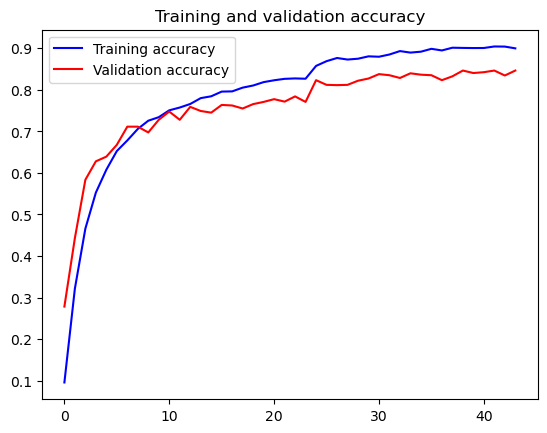

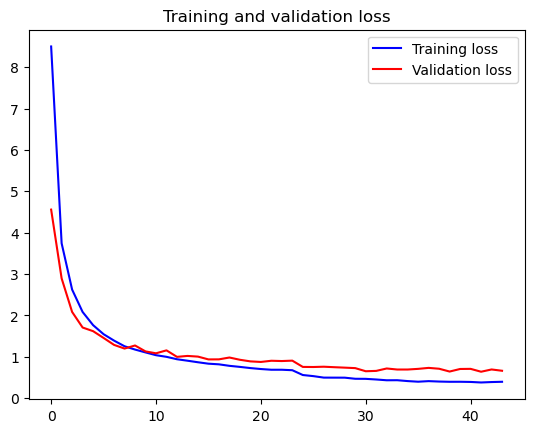

In [52]:
accuracy = model_log.history['accuracy']
val_accuracy = model_log.history['val_accuracy']

loss = model_log.history['loss']
val_loss = model_log.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [53]:
#Making some predctions based on the "test images" dataset
predictions = model.predict(test_images)

29/29 [==============================] - 4s 86ms/step


In [54]:
#Prediction will return an array with 100 positions, where each position is one class.
predictions[10]

array([2.98256738e-16, 1.00000000e+00, 3.19757555e-20, 2.37727473e-16,
       2.60339304e-19, 1.44666824e-14, 8.07662062e-16, 2.06719962e-18,
       2.06986666e-18, 2.10176996e-13, 5.25665421e-18, 5.23526448e-17,
       2.87339461e-19, 4.29889874e-11, 1.64228015e-16, 4.98778600e-20,
       2.25957360e-11, 1.22140132e-19, 2.78181680e-14, 5.73475892e-19,
       4.29843894e-15, 1.25901852e-13, 5.58114109e-14, 5.11654858e-16,
       5.82268066e-15, 1.12100753e-14, 1.50819339e-13, 2.18651120e-14,
       1.55349976e-14, 7.53017977e-19, 2.80880625e-17, 5.95320668e-11,
       2.49174791e-12, 2.80314139e-19, 5.26594448e-19, 3.77512500e-16,
       1.46508271e-16, 8.23734630e-20, 4.44568375e-19, 3.81252477e-14,
       2.23115805e-15, 8.90305286e-14, 2.08061004e-17, 4.60191743e-17,
       2.69953027e-12, 1.80361012e-15, 5.47365098e-18, 1.58816709e-17,
       2.74185362e-12, 4.47267150e-15, 4.87933792e-17, 1.18422130e-17,
       1.03981563e-15, 5.08125728e-19, 2.99552011e-16, 1.11455070e-16,
      

In [55]:
##### Checking the predction
np.argmax(predictions[10])

1

In [56]:
#We can also use it as the index of our class_names array and return the class...
class_names[np.argmax(predictions[10])]

'AMERICAN COOT'

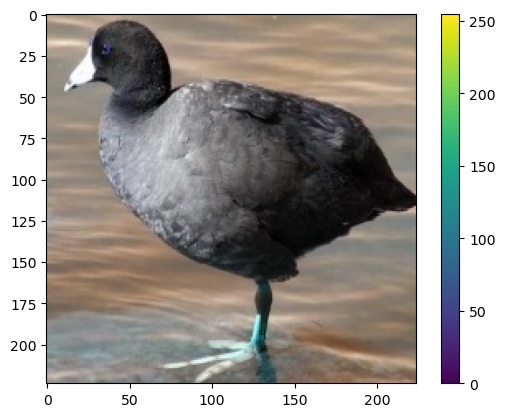

In [57]:
##### plt.figure()
plt.imshow(test_images[10])
plt.colorbar()
plt.grid(False)
plt.show()

In [58]:
class_names[test_labels[10]]

'AMERICAN COOT'

In [59]:
class_names[17]

'BROWN CREPPER'

In [60]:
pd.DataFrame(class_names).to_csv('class_names.csv')

In [61]:
result = pd.concat([pd.DataFrame({'Class': class_names}), pd.DataFrame({'Accuracy': accuracies}), pd.DataFrame({'Loss': losses})], axis=1)

In [62]:
result.head(5)

,Class,Accuracy,Loss
0,AMERICAN BITTERN,1.0,0.055737
1,AMERICAN COOT,1.0,0.056011
2,AMERICAN KESTREL,1.0,0.056404
3,AMERICAN PIPIT,0.7,0.606115
4,AMERICAN REDSTART,0.9,0.552020


In [63]:
pd.DataFrame(result).to_csv('result.csv')